In [26]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, ".."))

from scripts.logger import LoggerManager
from CICIDS2017.preprocessing.dataset import CICIDS2017

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
lm = LoggerManager(log_dir=f"{current_dir}/logs", log_name="test_dl_models")
lm.logger.info("Logger initialized")

dataset = CICIDS2017(logger=lm.logger).encode(attack_encoder="onehot").scale(scaler="minmax").optimize_memory()

2025-11-15 10:58:42,677 - INFO - Logger initialized
2025-11-15 10:58:42,678 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-15 10:58:43,093 - INFO - Loading data
2025-11-15 10:59:00,668 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-15 10:59:18,885 - INFO - ============================================================
2025-11-15 10:59:18,886 - INFO - Preprocessing completed successfully
2025-11-15 10:59:18,886 - INFO - Final dimensions: 1,942,693 rows x 71 columns
2025-11-15 10:59:18,887 - INFO - Total rows removed: 271,776 (12.27%)
2025-11-15 10:59:18,887 - INFO - data retention rate: 87.73%
2025-11-15 10:59:18,888 - INFO - ============================================================
2025-11-15 10:59:18,889 - INFO - Encoding attack labels...
2025-11-15 10:59:19,736 - INFO - Attack labels encoded using onehot encoder.
2025-11-15 10:59:19,737 - INFO - Scaling dataset features...
2025-11-15 10:59:46,935 - INFO - Features scaled 

In [28]:
def train_nids_model(model, optimizer, scheduler, criterion, train_loader, val_loader, device, epochs=25):
    epoch_losses = []
    epoch_val_losses = []
    # Training loop
    tqdm_epochs = tqdm(range(int(epochs)), desc="Training Progress")
    for epoch in tqdm_epochs:
        model.train()
        losses = []
        for X_train, y_train in train_loader:
            # Forward pass
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            losses.append(loss)

        epoch_loss = sum(losses) / len(losses)
        epoch_losses.append(epoch_loss.cpu().detach().numpy())
            
        # Backward pass and optimization
        optimizer.zero_grad()
        epoch_loss.backward()
        optimizer.step()

        scheduler.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_losses = []
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                val_losses.append(val_loss)

            epoch_val_loss = sum(val_losses) / len(val_losses)
            epoch_val_losses.append(epoch_val_loss.cpu().detach().numpy())
            
        tqdm_epochs.set_description(f"Loss: {epoch_loss.item():.4f}, Val Loss: {epoch_val_loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    return model, epoch_losses, epoch_val_losses


In [29]:
def display_loss(list_epoch_loss, list_val_loss, title, dir, logger, epoch_min=2):
    lm.logger.info("Plotting loss curve...")
    # Plotting loss curve with linear and log scale
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(list_epoch_loss[epoch_min:], label='Training Loss')
    plt.plot(list_val_loss[epoch_min:], '-r', label='Validation Loss')
    plt.title(f"Loss Curve - {title}")  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(list_epoch_loss[epoch_min:], label='Training Loss')
    plt.plot(list_val_loss[epoch_min:], '-r', label='Validation Loss') 
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    loss_plot_path = f"{dir}/loss_img/{title}_loss.png"
    os.makedirs(f"{dir}/loss_img", exist_ok=True)
    plt.savefig(loss_plot_path, bbox_inches='tight', dpi=300)
    lm.logger.info(f"Loss curve saved as {loss_plot_path}")
    plt.show()

In [30]:
X = torch.FloatTensor(dataset.scaled_features).to(device)
y = torch.FloatTensor(dataset.attack_classes).to(device)

dataset_size = len(X)

# Randomly get a subset of the data
subset_size = min(50000, dataset_size)
indices = torch.randperm(dataset_size)[:subset_size]
X = X[indices]
y = y[indices]


In [31]:
# Dsiplay num of elements per class
unique, counts = torch.unique(torch.argmax(y, dim=1), return_counts=True)
class_distribution = dict(zip(unique.cpu().numpy(), counts.cpu().numpy()))
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

Class 0: 39081 samples
Class 1: 56 samples
Class 2: 3371 samples
Class 3: 5118 samples
Class 4: 1 samples
Class 5: 2 samples
Class 6: 2371 samples


In [32]:
dataset_tensor = TensorDataset(X, y)
del X, y

train_size = int(0.8 * len(dataset_tensor))
val_size = len(dataset_tensor) - train_size

print(f"Dataset size: {len(dataset_tensor)}, Train size: {train_size}, Val size: {val_size}")

Dataset size: 50000, Train size: 40000, Val size: 10000


In [33]:
train_dataset, val_dataset = random_split(dataset_tensor, [train_size, val_size])

In [34]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [69]:
input_size = dataset.scaled_features.shape[1]
num_classes = len(dataset.attack_classes[0])
print(f"Input size: {input_size}, Num classes: {num_classes}")  

criterion = nn.CrossEntropyLoss()

Input size: 70, Num classes: 7


In [52]:
class NetworkIntrusionMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NetworkIntrusionMLP, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(32, 16),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(16, num_classes),
        )

    def forward(self, x):
        features = self.features(x)
        out = self.classifier(features)
        return torch.softmax(out, dim=1)

In [ ]:
model_mlp = NetworkIntrusionMLP(input_size=input_size, num_classes=num_classes).to(device)

learning_rate_mlp = 1e-2
num_epochs_mlp = 50

optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=learning_rate_mlp)
scheduler_mlp = optim.lr_scheduler.PolynomialLR(optimizer_mlp, total_iters=num_epochs_mlp, power=2)

In [77]:
model_mlp, train_losses_mlp, val_losses_mlp = train_nids_model(
    model=model_mlp,
    optimizer=optimizer_mlp,
    scheduler=scheduler_mlp,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_mlp
)

Loss: 1.9207, Val Loss: 1.9203, LR: 0.000000: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


2025-11-15 11:18:56,815 - INFO - Plotting loss curve...
2025-11-15 11:18:57,407 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/CICIDS2017/loss_img/MLP_NIDS_loss.png


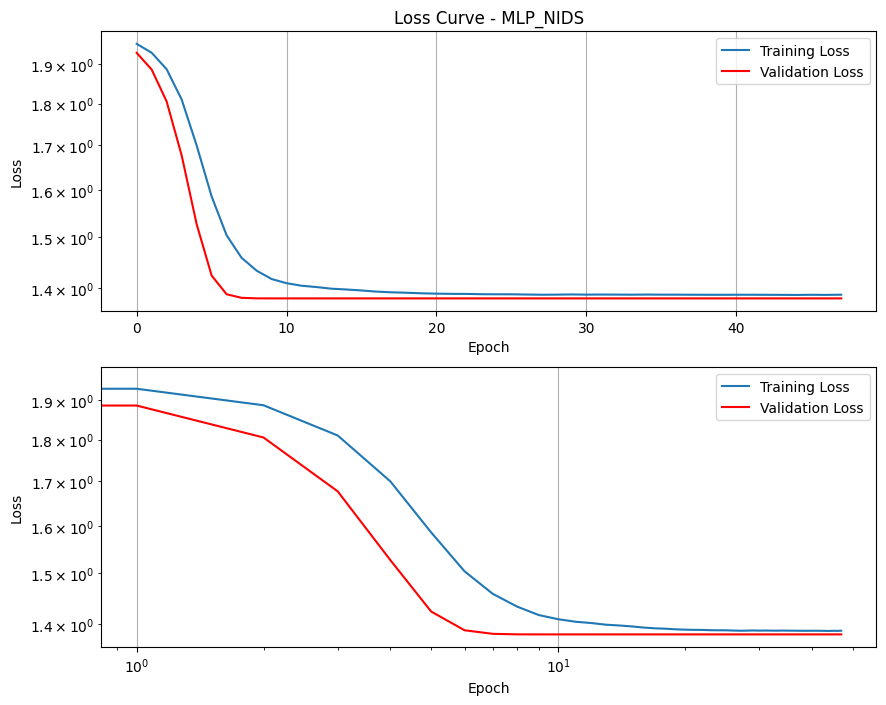

In [75]:
display_loss(
    list_epoch_loss=train_losses_mlp,
    list_val_loss=val_losses_mlp,
    title="MLP_NIDS",
    dir=current_dir,
    logger=lm.logger,
    epoch_min=2
)

In [40]:
class NetworkIntrustionCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(NetworkIntrustionCNN, self).__init__()
        
        self.features = nn.Sequential(
            # 1D Convolutional Layers
            nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * (input_size // 4), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Reshape input for 1D convolution
        x = x.unsqueeze(1)  # Add channel dimension
        features = self.features(x)
        features = features.view(features.size(0), -1)
        out = self.classifier(features)
        return torch.softmax(out, dim=1)

In [44]:
model_cnn = NetworkIntrustionCNN(input_channels=1, num_classes=num_classes).to(device)

learning_rate_cnn = 1e-2
num_epochs_cnn = 100

optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=learning_rate_cnn)
scheduler_cnn = optim.lr_scheduler.PolynomialLR(optimizer_cnn, total_iters=num_epochs_cnn, power=0.9)

In [46]:
model_cnn, train_loss_cnn, val_loss_cnn = train_nids_model(
    model=model_cnn,
    optimizer=optimizer_cnn,
    scheduler=scheduler_cnn,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_cnn
)

Loss: 1.3846, Val Loss: 1.3799, LR: 0.000000: 100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


2025-11-15 11:05:30,500 - INFO - Plotting loss curve...
2025-11-15 11:05:31,099 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/CICIDS2017/loss_img/NetworkIntrustionCNN_loss.png


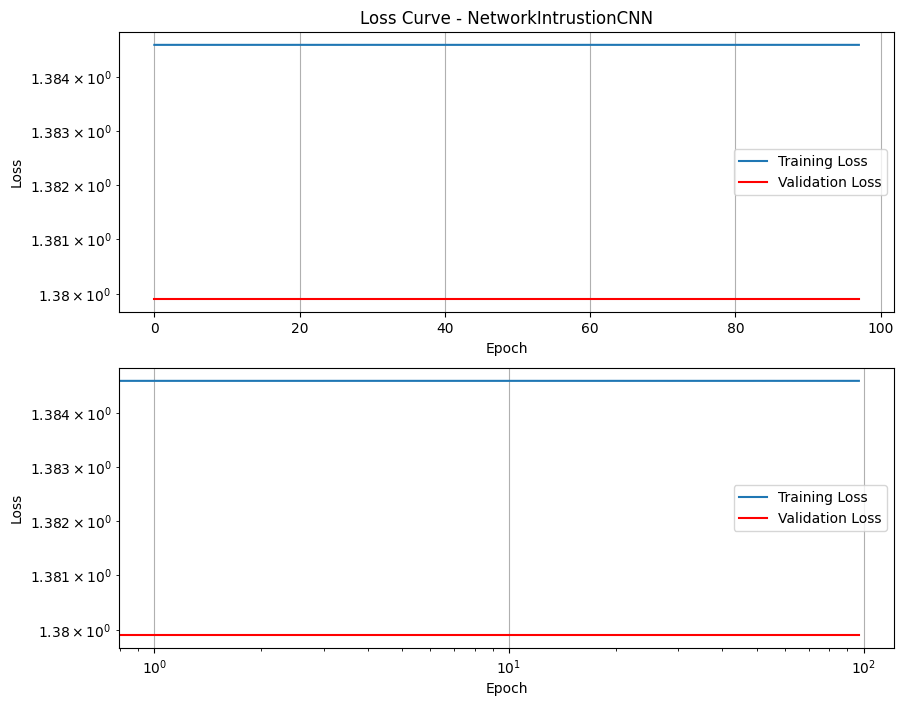

In [47]:
display_loss(
    train_loss_cnn,
    val_loss_cnn,
    title="NetworkIntrustionCNN",
    dir=current_dir,
    logger=lm.logger,
    epoch_min=2
)

In [48]:
class NetworkIntrusionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(NetworkIntrusionLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # LSTM expects (batch, seq_len, features)
        lstm_out, _ = self.lstm(x)
        # Use the last time step
        out = lstm_out
        out = self.classifier(out)
        return torch.softmax(out, dim=1)

In [49]:
model_lstm = NetworkIntrusionLSTM(input_size=input_size, hidden_size=128, num_layers=3, num_classes=num_classes).to(device)

learning_rate_lstm = 1e-2
num_epochs_lstm = 100

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate_lstm)
scheduler_lstm = optim.lr_scheduler.PolynomialLR(optimizer_lstm, total_iters=num_epochs_lstm, power=0.9)

In [51]:
model_lstm, train_loss_lstm, val_loss_lstm = train_nids_model(
    model=model_lstm,
    optimizer=optimizer_lstm,
    scheduler=scheduler_lstm,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_lstm
)

Loss: 1.3846, Val Loss: 1.3799, LR: 0.000000: 100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


2025-11-15 10:56:21,898 - INFO - Plotting loss curve...
2025-11-15 10:56:22,522 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/CICIDS2017/loss_img/LSTM_NIDS_Model_loss.png


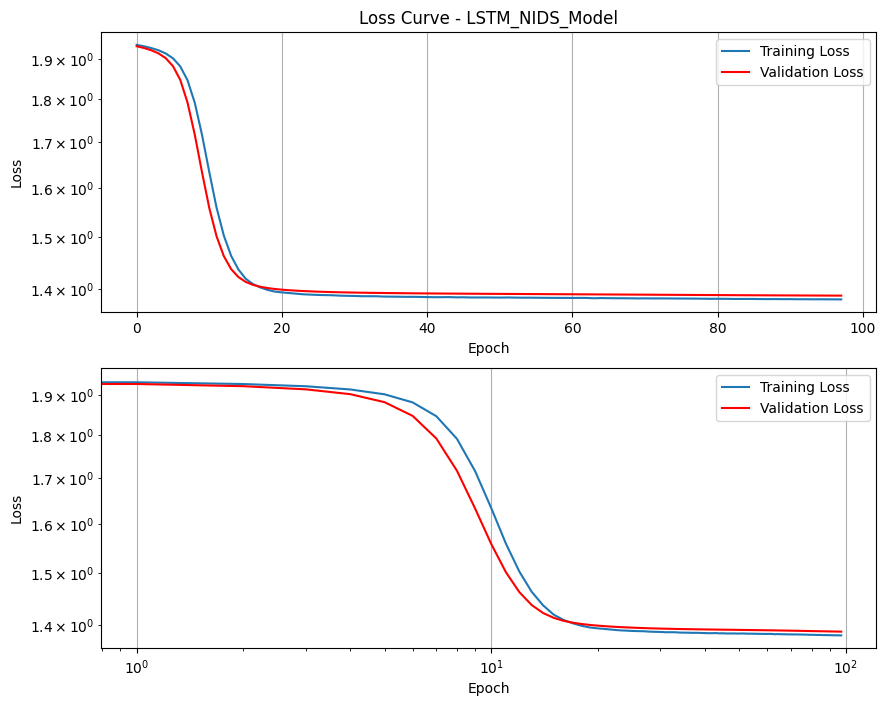

In [ ]:
display_loss(
    train_loss_lstm, 
    val_loss_lstm, 
    title="LSTM_NIDS_Model", 
    dir=current_dir, 
    logger=lm.logger,
    epoch_min=2
)